In [1]:
import warnings
warnings.filterwarnings('ignore',category=RuntimeWarning)
import xarray as xr
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import glob,os,sys
from tqdm.auto import tqdm
import proplot as plot
import json,pickle
import dask.array as da
import gc
from sklearn.decomposition import PCA
sys.path.insert(1, '/work/FAC/FGSE/IDYST/tbeucler/default/freddy0218/TCGphy/2020_TC_CRF/dev/freddy0218/')
from tools import derive_var,read_and_proc,preproc_noensemble,plotting
from tools.mlr import mlr,proc_mlrfcst,maria_IO
from tools.preprocess import do_eof,preproc_maria,preproc_haiyan
sys.path.insert(2, '/work/FAC/FGSE/IDYST/tbeucler/default/freddy0218/TCGphy/testML/')
import feature_select
from dask.distributed import Client
client = Client(processes=True, threads_per_worker=1,n_workers=2)
%matplotlib inline
plot.rc.update({'figure.facecolor':'w','axes.labelweight':'ultralight',
                'tick.labelweight':'ultralight','gridminor.linestyle':'--','title.weight':'normal','linewidth':0.5})

distributed.diskutils - INFO - Found stale lock file and directory '/work/FAC/FGSE/IDYST/tbeucler/default/freddy0218/TCGphy/testML/haiyan/dask-worker-space/worker-g6t2ne8w', purging
distributed.diskutils - INFO - Found stale lock file and directory '/work/FAC/FGSE/IDYST/tbeucler/default/freddy0218/TCGphy/testML/haiyan/dask-worker-space/worker-bmh3aqsu', purging
/tmp/ipykernel_800700/453806833.py:24: ProplotWarning: rc setting 'linewidth' was renamed to 'meta.width' in version 0.8.
  plot.rc.update({'figure.facecolor':'w','axes.labelweight':'ultralight',


In [2]:
def forward_diff(arrayin=None,delta=None,axis=None,LT=1):
    result = []
    if axis==0:
        for i in range(0,arrayin.shape[axis]-LT):
            temp = (arrayin[i+LT,:]-arrayin[i,:])/(LT*delta)
            result.append(temp)
        return np.asarray(result)
    
class retrieve_cartesian:
    def __init__(self,PCA_dict=None,Af_dict=None,numcomp=[11,11,15],LT=None,forecastPC=None,target='all',suffix=None):
        self.PCA_dict=PCA_dict
        self.numcomp=numcomp
        self.forecastPC = forecastPC
        self.LT = LT
        self.target=target
        self.suffix=suffix
        
    def get_time_diff_terms(self,inputvar=None,LT=None,wantvar=None):
        def _get_time_diff(array=None,timedelta=60*60,LT=None):
            store = []
            for exp in array:
                a = forward_diff(exp,timedelta,0,LT)
                if a.shape[0]>0:
                    azero = np.zeros((LT,exp.shape[-1]))
                    store.append(np.asarray(a))
                    #store.append(np.concatenate((a,azero),axis=0))
                else:
                    continue
                    #store.append(np.zeros((exp.shape[0],exp.shape[-1])))
            return store
        
        storedict = {}
        for wantvarZ,wantvarN in enumerate(wantvar):
            storedict[wantvarN] = _get_time_diff(array=inputvar[wantvarZ],LT=LT)
        return storedict
    
    def _pop_valid_test(self,examplist=None,validindex=None,testindex=None):
        [examplist.pop(i) for i in validindex]
        [examplist.pop(i) for i in testindex]
        return None
        
    def windrates_real(self,uvwheatpath=None,LT=None,category='train',validindex=[1,6],testindex=[2,12]):
        u = [read_and_proc.depickle(path+uvwheatpath+'mem'+str(lime)+self.suffix)['u'] for lime in tqdm(range(1,21))].copy()
        v = [read_and_proc.depickle(path+uvwheatpath+'mem'+str(lime)+self.suffix)['v'] for lime in tqdm(range(1,21))].copy()
        w = [read_and_proc.depickle(path+uvwheatpath+'mem'+str(lime)+self.suffix)['w'] for lime in tqdm(range(1,21))].copy()
        theta = [read_and_proc.depickle(path+uvwheatpath+'mem'+str(lime)+self.suffix)['theta'] for lime in tqdm(range(1,21))].copy()
        
        if category=='train':
            self._pop_valid_test(u,validindex,testindex)
            self._pop_valid_test(v,validindex,testindex)
            self._pop_valid_test(w,validindex,testindex)
            self._pop_valid_test(theta,validindex,testindex)
            assert len(u)==16, 'wrong train-valid-test separation!'
            dtermsT = self.get_time_diff_terms(inputvar=[u,v,w,theta],LT=LT,wantvar=['u','v','w','theta'])
        elif category=='valid':
            uv = [u[index] for index in validindex]
            vv = [v[index] for index in validindex]
            wv = [w[index] for index in validindex]
            thetav = [theta[index] for index in validindex]
            del u,v,w,theta
            gc.collect()
            dtermsT = self.get_time_diff_terms(inputvar=[uv,vv,wv,thetav],LT=LT,wantvar=['u','v','w','theta'])
        elif category=='test':
            ut = [u[index] for index in testindex]
            vt = [v[index] for index in testindex]
            wt = [w[index] for index in testindex]
            thetat = [theta[index] for index in testindex]            
            del u,v,w,theta
            gc.collect()
            dtermsT = self.get_time_diff_terms(inputvar=[ut,vt,wt,thetat],LT=LT,wantvar=['u','v','w','theta'])            
        
        dudt = np.concatenate([testx for testx in dtermsT['u']],axis=0)
        dvdt = np.concatenate([testx for testx in dtermsT['v']],axis=0)
        dwdt = np.concatenate([testx for testx in dtermsT['w']],axis=0)
        dthdt = np.concatenate([testx for testx in dtermsT['theta']],axis=0)
        del dtermsT
        gc.collect()
        return dudt,dvdt,dwdt,dthdt

Read data
---------------------------------
Read in flattened data and PCA objects

In [3]:
path = '/work/FAC/FGSE/IDYST/tbeucler/default/freddy0218/'
suffix = '_smooth_preproc_dict1b_g'
a = [read_and_proc.depickle(path+'TCGphy/testML/output/haiyan/processed/uvwheat/'+'mem'+str(lime)+suffix)['u'].shape for lime in tqdm(range(1,21))]
# divide experiments reference
divider = np.asarray([aobj[0] for aobj in a]).cumsum()

haiyan_u = np.concatenate([read_and_proc.depickle(path+'TCGphy/testML/output/haiyan/processed/uvwheat/'+'mem'+str(lime)+suffix)['u'] for lime in tqdm(range(1,21))],axis=0)
haiyan_v = np.concatenate([read_and_proc.depickle(path+'TCGphy/testML/output/haiyan/processed/uvwheat/'+'mem'+str(lime)+suffix)['v'] for lime in tqdm(range(1,21))],axis=0)
haiyan_w = np.concatenate([read_and_proc.depickle(path+'TCGphy/testML/output/haiyan/processed/uvwheat/'+'mem'+str(lime)+suffix)['w'] for lime in tqdm(range(1,21))],axis=0)
haiyan_theta = np.concatenate([read_and_proc.depickle(path+'TCGphy/testML/output/haiyan/processed/uvwheat/'+'mem'+str(lime)+suffix)['theta'] for lime in tqdm(range(1,21))],axis=0)
haiyan_rad = np.concatenate([read_and_proc.depickle(path+'TCGphy/testML/output/haiyan/processed/uvwheat/'+'mem'+str(lime)+suffix)['rad'] for lime in tqdm(range(1,21))],axis=0)

folderpath='/work/FAC/FGSE/IDYST/tbeucler/default/freddy0218/TCGphy/testML/output/haiyan/processed/'
PCAdict,dict2 = read_and_proc.depickle(folderpath+'pca/PCA'+'_'+'dict1_g'),read_and_proc.depickle(folderpath+'pca/PCA'+'_'+'dict2_g') #dict1: u,v,w,theta,hdia,rad; dict2:qv,ir
PCAdict['qv'] = (dict2['qv'])
PCAdict['ir'] = (dict2['ir'])

dims = ['sample','flatarray']
coords = dict(sample=np.linspace(0,haiyan_u.shape[0]-1,haiyan_u.shape[0]),flatarray=np.linspace(0,haiyan_u.shape[1]-1,haiyan_u.shape[1]))
ds = xr.Dataset(coords=coords)
haiyan_data=preproc_haiyan.build_a_xarray_dataset(ds=ds,varname=['u','v','w','theta','rad'],varfile=[haiyan_u,haiyan_v,haiyan_w,haiyan_theta,haiyan_rad],dims=dims,coords=coords)
del haiyan_u,haiyan_v,haiyan_w,haiyan_theta
gc.collect()

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

220

Test randomized structures
---------------------------------

In [4]:
RADtimeseries = PCAdict['rad'].transform(haiyan_data['rad'].data)[:,0:10]
RADstructures = (PCAdict['rad'].components_)[0:10,:].reshape(10,10,360,208)

In [5]:
RADstructures_azimean = np.nanmean(RADstructures,axis=2)

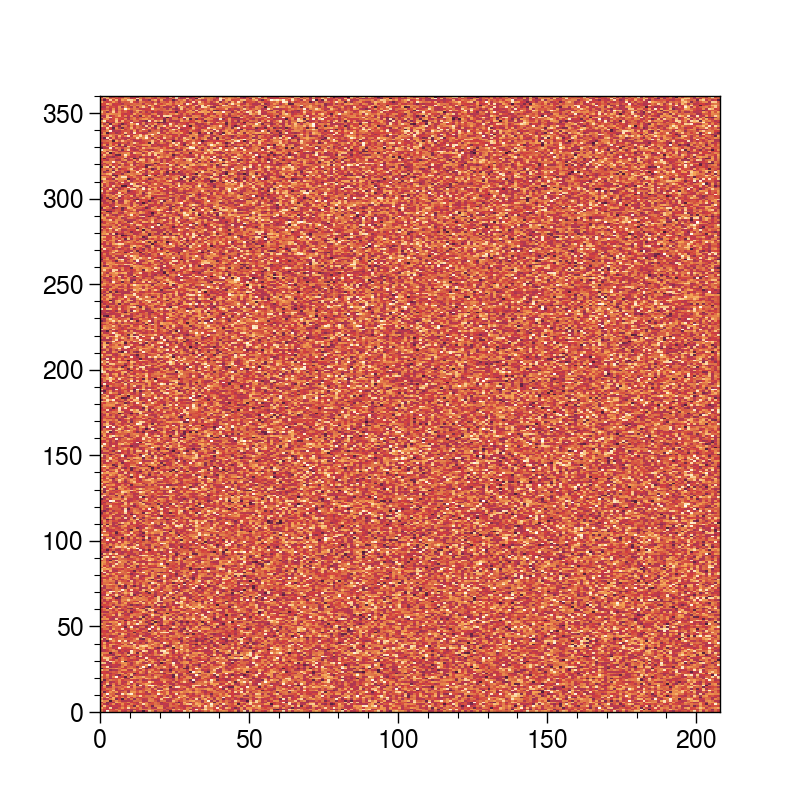

In [6]:
import random
plt.pcolormesh(np.asarray(random.sample(list(RADstructures[1,0,...].flatten()), len(list(RADstructures[1,0,...].flatten())))).reshape(360,208))
plt.show()

In [292]:
import numpy as np
from numpy.linalg import svd


def rank(A, atol=1e-13, rtol=0):
    A = np.atleast_2d(A)
    s = svd(A, compute_uv=False)
    tol = max(atol, rtol * s[0])
    rank = int((s >= tol).sum())
    return rank


def nullspace(A, atol=1e-13, rtol=0):
    A = np.atleast_2d(A)
    u, s, vh = svd(A)
    tol = max(atol, rtol * s[0])
    nnz = (s >= tol).sum()
    ns = vh[nnz:].conj().T
    return ns

def randsol(A, b, num=1, check=False):
    xLS = RADstructures_azimean.reshape(10,10*208)#np.linalg.lstsq(A, b)

    colsOfNullspace = nullspace(A)
    nullrank = colsOfNullspace.shape[1]
    if check:
        assert(np.allclose(np.dot(A, xLS), b))
        assert(np.allclose(np.dot(A, xLS + np.transpose(np.tile(np.dot(colsOfNullspace,
                                                  np.random.randn(nullrank)),(2080,1)))),
                           b))

    #sols = xLS[:, np.newaxis] + np.dot(colsOfNullspace,
    #                                   np.random.randn(nullrank, num))
    return np.dot(colsOfNullspace,np.random.randn(nullrank))

In [293]:
testrad = A+randsol(A, b, num=10, check=True)

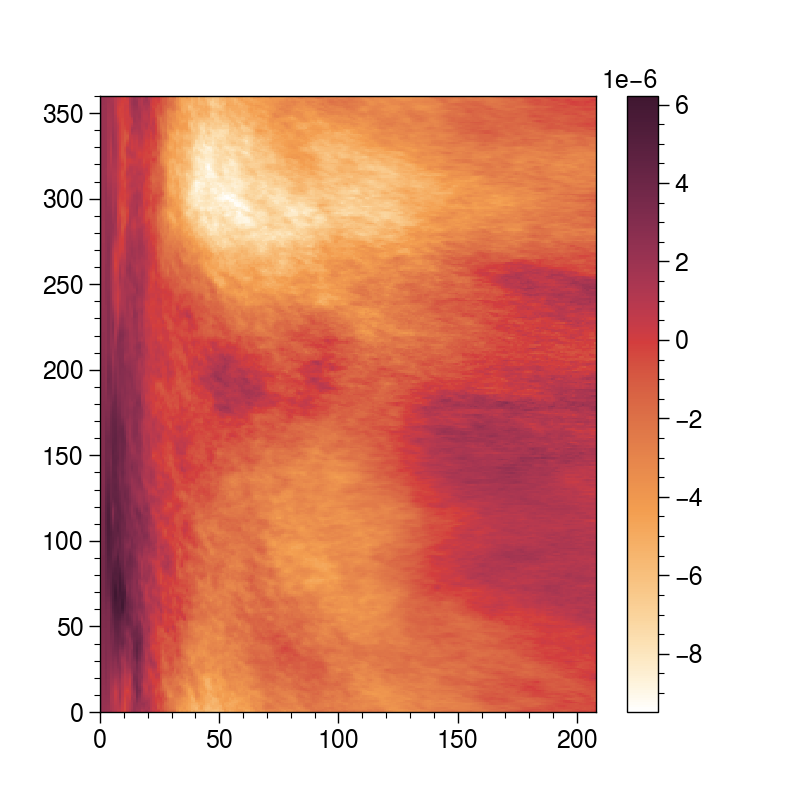

In [314]:
testrad = A+randsol(A, b, num=10, check=True)*1e-3
plt.pcolormesh((np.dot(RADtimeseries[25,:],PCAdict['rad'].components_[0:10,:]).reshape(10,360,208))[0,:,:]-(np.dot(testrad,PCAdict['rad'].components_[0:10,:]).reshape(10,360,208))[0,:,:])#,vmin=-0.0001,vmax=0.0001,cmap='balance')
plt.colorbar()
plt.show()

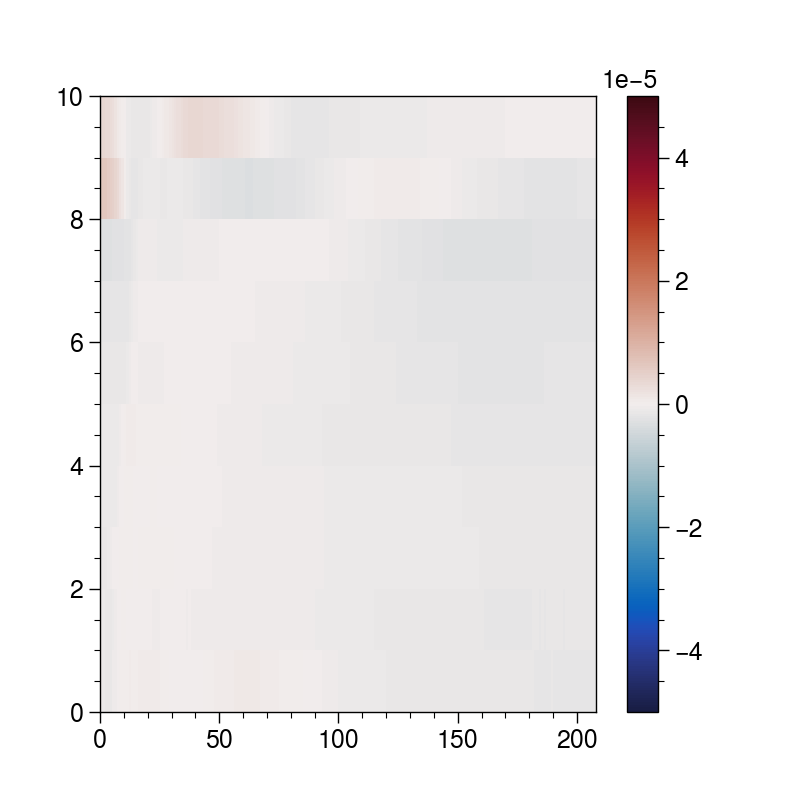

In [323]:
plt.pcolormesh(np.dot(A+randsol(A, b, num=10, check=True)*1e-3,RADstructures_azimean.reshape(10,10*208)).reshape(10,208)-\
               np.nanmean(np.dot(RADtimeseries[25,:],PCAdict['rad'].components_[0:10,:]).reshape(10,360,208),axis=1),vmin=-0.00005,vmax=0.00005,cmap='balance')
plt.colorbar()
plt.show()

In [233]:
A, b = RADtimeseries[25,:],np.dot(RADtimeseries[25,:],RADstructures_azimean.reshape(10,10*208))
randsol(A, b, num=10, check=True)

(10, 9) [ 0.75118747 -0.57852328 -0.78481576  0.72167853 -0.25070372 -0.14821621
  1.45845459 -0.54798914 -0.36095672]


array([ 0.31417427, -1.68720654, -1.04569554,  1.88041304,  0.39433339,
        0.15397457,  1.46808118, -0.66143381,  0.4001116 , -0.40163149])

In [101]:
ans = np.dot(RADtimeseries[25,:],RADstructures_azimean.reshape(10,10*208)).reshape(10,208)

testcoef,sols = [],[]
for _ in range(1000000):
    rand_sample = np.random.uniform(low=np.min(RADtimeseries[25,:]), high=np.max(RADtimeseries[25,:]), size=(10,))#np.random.permutation(RADtimeseries[25,:])
    testsol = np.dot(rand_sample,RADstructures_azimean.reshape(10,10*208)).reshape(10,208)
    if np.sqrt(np.mean(testsol**2 - ans**2))<1e-9:
        print('find one')
        sols.append(rand_sample)
        testcoef.append(testsol)
    else:
        continue

/tmp/ipykernel_800700/1442961989.py:4: ProplotWarning: rc setting 'linewidth' was renamed to 'meta.width' in version 0.8.
  plot.rc.update({'axes.labelweight':'normal','tick.labelweight':'normal','figure.facecolor':'k','suptitle.color':'w','title.color':'w','fontname': 'Source Sans Pro', 'fontsize': 13,'linewidth':1.25})


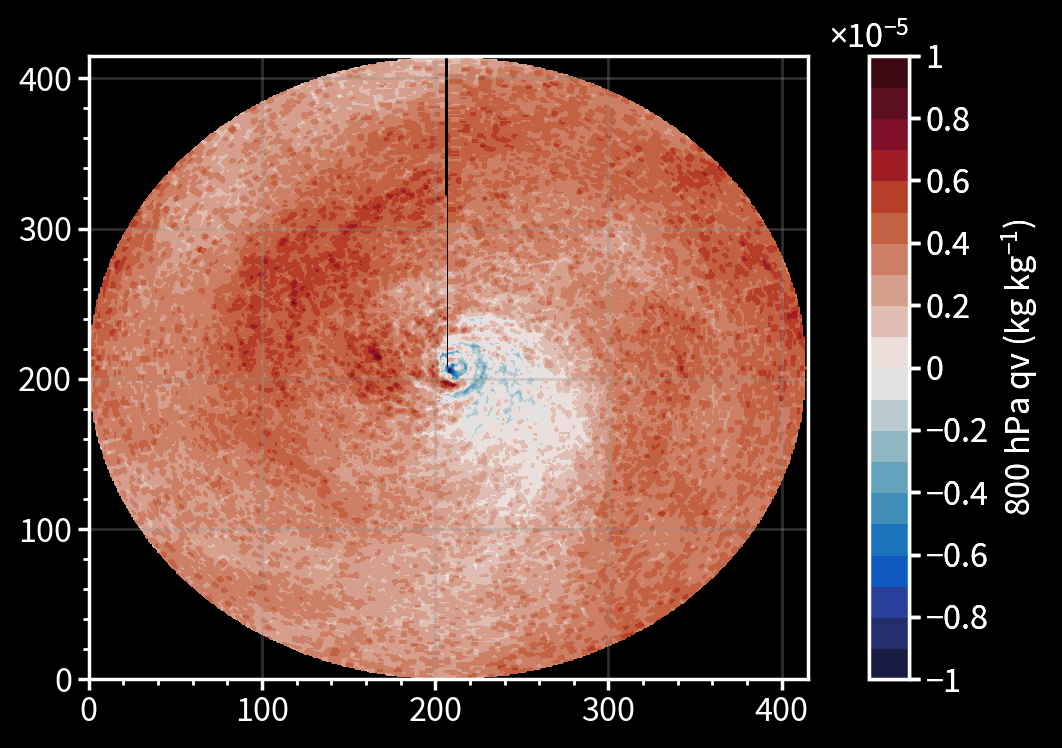

In [29]:
ANGLE = read_and_proc.azimuth2angle(np.linspace(0,359,360))
NEWCART_axis = np.concatenate((np.flipud(-np.linspace(0,207,208)*3),np.linspace(0,207,208)*3))
plot.rc.metacolor = 'w'
plot.rc.update({'axes.labelweight':'normal','tick.labelweight':'normal','figure.facecolor':'k','suptitle.color':'w','title.color':'w','fontname': 'Source Sans Pro', 'fontsize': 13,'linewidth':1.25})
plot.rc.axesfacecolor = 'k'

fig,axs = plot.subplots(ncols=1,nrows=1,axwidth=3.595,refaspect=1.1531)
ct0 = axs[0].contourf(np.ma.masked_equal(np.fliplr(np.flipud((read_and_proc.proc_tocart((np.dot(RADtimeseries[75,:],PCAdict['rad'].components_[0:10,:]).reshape(10,360,208))[2,:,:],
                                                                                 ANGLE,True,False)))),0),levels=np.linspace(-0.00001,0.00001,21),cmap='balance')
axs[0].colorbar(ct0,label='800 hPa qv (kg kg$^{-1}$)')
axs[0].grid(alpha=0.3,color='gray',linewidth=1)
plt.show()

In [12]:
from sklearn.linear_model import LinearRegression

In [101]:
timeindex = 75
nums = []
def ta():
    val = np.random.uniform(np.min(RADtimeseries[timeindex,:]),np.max(RADtimeseries[timeindex,:]))
    total = (np.dot(RADtimeseries[timeindex,:],RADstructures_azimean.reshape(10,10*208)))#-np.random.uniform(np.min(RADtimeseries[25,:]),np.max(RADtimeseries[25,:]))
    val2 = np.random.uniform(np.min(RADtimeseries[timeindex,:]),np.max(RADtimeseries[timeindex,:]))
    #start = np.subtract(total,np.dot(val,RADstructures_azimean[0,:]).reshape(10*208)).flatten()
    start = np.subtract(np.subtract(total,np.dot(val,RADstructures_azimean[0,:]).reshape(10*208)),\
                        np.dot(val2,RADstructures_azimean[1,:]).reshape(10*208)).flatten()
    reg = LinearRegression().fit(np.transpose(np.asarray([RADstructures_azimean[2:][i].flatten() for i in range(8)])), start)
    return np.dot(np.asarray([val,val2]+list(reg.coef_)),RADstructures_azimean.reshape(10,10*208)).reshape(10,208),[val,val2]+list(reg.coef_)


In [106]:
a,emulated = [],[]
for _ in tqdm(range(20)):
    emulate,coeff = ta()
    emulated.append(emulate)
    a.append(coeff)
    if np.array_equal(emulate,np.nanmean(np.dot(RADtimeseries[75,:],PCAdict['rad'].components_[0:10,:]).reshape(10,360,208),axis=1)):
        print('find')

  0%|          | 0/20 [00:00<?, ?it/s]

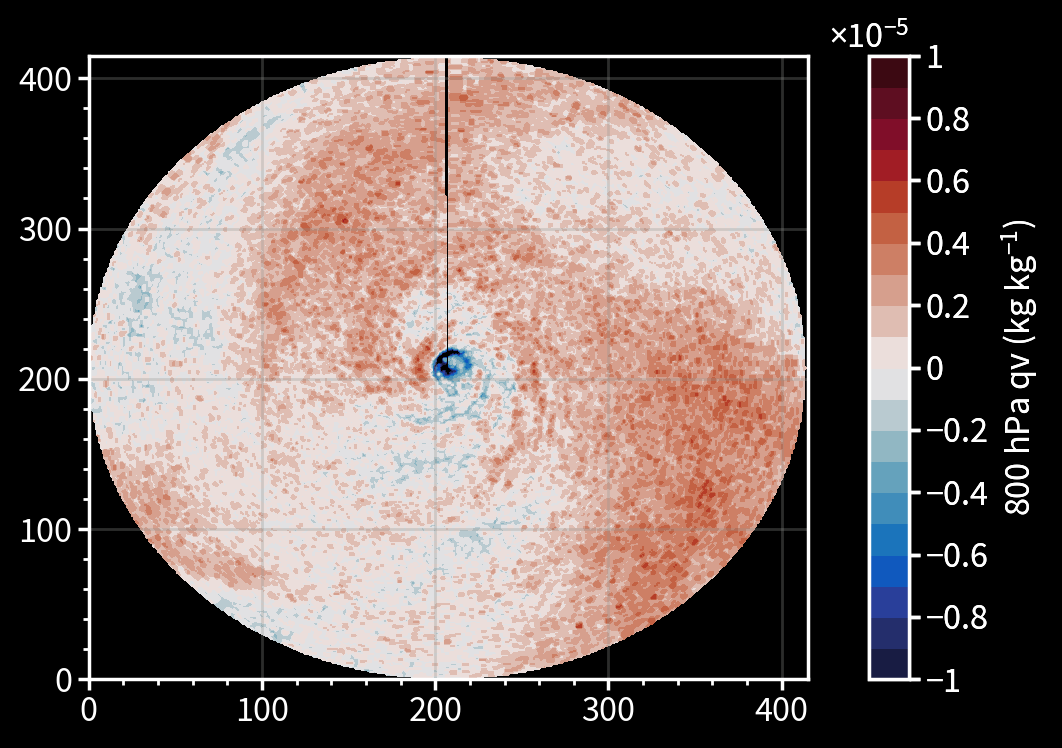

In [110]:
fig,axs = plot.subplots(ncols=1,nrows=1,axwidth=3.595,refaspect=1.1531)
ct0 = axs[0].contourf(np.ma.masked_equal(np.fliplr(np.flipud((read_and_proc.proc_tocart((np.dot(a[5],PCAdict['rad'].components_[0:10,:]).reshape(10,360,208))[2,:,:],
                                                                                 ANGLE,True,False)))),0),levels=np.linspace(-0.00001,0.00001,21),cmap='balance')
axs[0].colorbar(ct0,label='800 hPa qv (kg kg$^{-1}$)')
axs[0].grid(alpha=0.3,color='gray',linewidth=1)
plt.show()

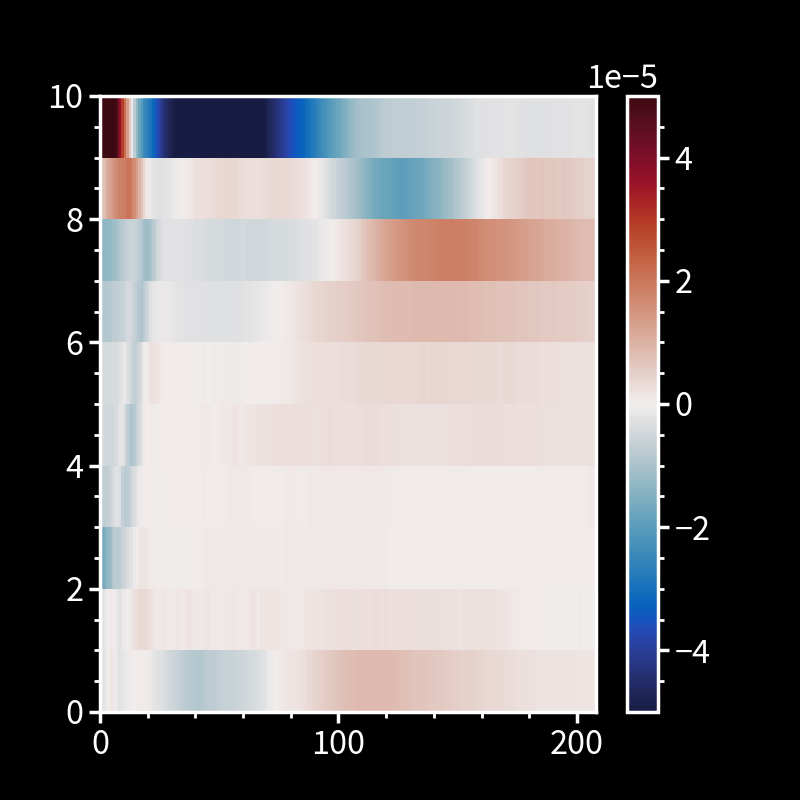

In [73]:
plt.pcolormesh(np.dot(np.asarray([val]+list(reg.coef_)),RADstructures_azimean.reshape(10,10*208)).reshape(10,208),vmin=-0.00005,vmax=0.00005,cmap='balance')
plt.colorbar()
plt.show()

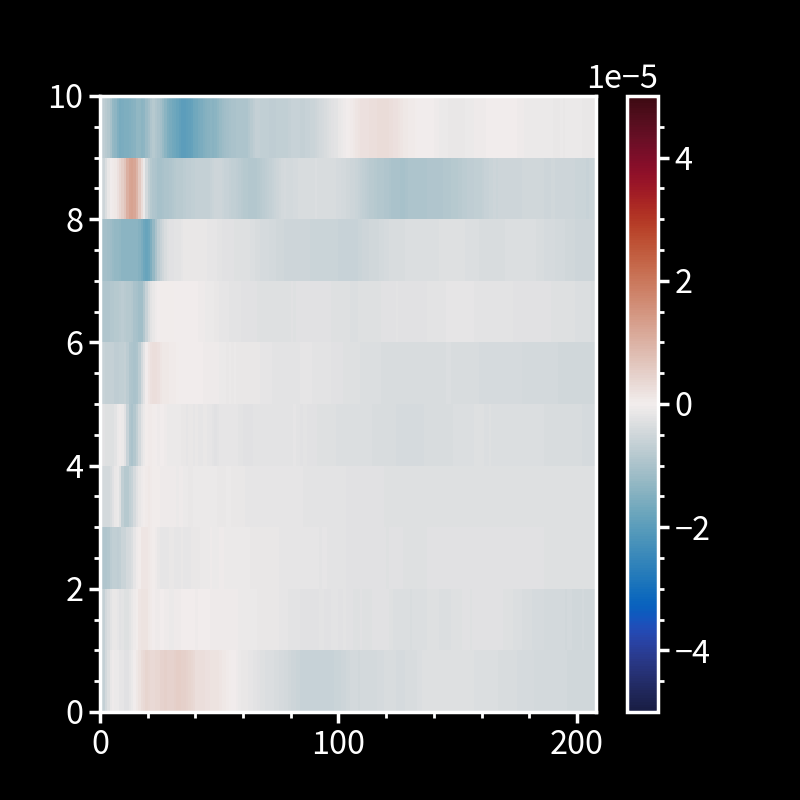

In [74]:
plt.pcolormesh(np.dot(np.asarray([val]+list(reg.coef_)),RADstructures_azimean.reshape(10,10*208)).reshape(10,208)-\
               np.nanmean(np.dot(RADtimeseries[75,:],PCAdict['rad'].components_[0:10,:]).reshape(10,360,208),axis=1),vmin=-0.00005,vmax=0.00005,cmap='balance')
plt.colorbar()
plt.show()

In [159]:
import numpy as np
from scipy.linalg import qr


def qr_null(A, tol=None):
    """Computes the null space of A using a rank-revealing QR decomposition"""
    Q, R, P = qr(A.T, mode='full', pivoting=True)
    tol = np.finfo(R.dtype).eps if tol is None else tol
    rnk = min(A.shape) - np.abs(np.diag(R))[::-1].searchsorted(tol)
    return Q[:, rnk:].conj()


# An underdetermined system with nullity 2
A = np.array([[1, 4, 9, 6, 9, 2, 7],
              [6, 3, 8, 5, 2, 7, 6],
              [7, 4, 5, 7, 6, 3, 2],
              [5, 2, 7, 4, 7, 5, 4],
              [9, 3, 8, 6, 7, 3, 1]])
b = np.array([0, 4, 1, 3, 2])

# Find an initial solution using `np.linalg.lstsq`
x_lstsq = np.linalg.lstsq(A, b)[0]

# Compute the null space of `A`
Z = qr_null(A)
nullity = Z.shape[1]

# Sample some random solutions
for _ in range(10):
    x_rand = x_lstsq + Z.dot(np.random.rand(nullity))
    # If `x_rand` is a solution then `||A·x_rand - b||` should be very small
    print(x_rand)
    #print(np.linalg.norm(A.dot(x_rand) - b))

[ 0.34731063 -0.12207526 -0.00417553 -0.39006671  0.0199358   0.42017049
  0.21417245]
[ 0.50072615  0.34993766 -0.06669411 -0.80783626  0.06455675  0.34949982
  0.32382533]
[ 0.46388505 -0.03597915 -0.0623061  -0.52948767  0.03801218  0.33264358
  0.34433081]
[ 0.42883227 -0.1836433  -0.04957384 -0.40802816  0.02550469  0.34384906
  0.32611917]
[ 0.49232371 -0.12200595 -0.08065944 -0.49359386  0.03620621  0.29800816
  0.39447514]
[ 0.61379924  0.21149519 -0.13173081 -0.798103    0.06920035  0.23705636
  0.48821421]
[ 0.60360037  0.22578003 -0.12579461 -0.80015508  0.06888591  0.24742156
  0.47307787]
[ 0.45015415  0.11685837 -0.04910592 -0.61951392  0.04534797  0.36317952
  0.30099405]
[ 0.55021895  0.27736753 -0.09562781 -0.79575588  0.06589396  0.29879671
  0.39783679]
[ 0.42887736  0.09572771 -0.03870726 -0.59052939  0.04173415  0.37848242
  0.27816876]


/tmp/ipykernel_1826020/2775083543.py:22: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  x_lstsq = np.linalg.lstsq(A, b)[0]


In [57]:
solution_vec.shape

(20800, 208)